# Apple stock price prediction and the risk assesment.

# Importing Libraries

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from keras.models import Sequential
from keras.layers import LSTM, Dense

# Function to plot data

In [2]:
def plot_data(y_actual, y_predicted, title, xlabel, ylabel, legend_labels):
    plt.figure(figsize=(15, 10))
    plt.plot(y_actual, label=legend_labels[0])
    plt.plot(y_predicted, label=legend_labels[1], alpha=0.7)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True)
    plt.show()


# Loading the Dataset

In [3]:
data = pd.read_csv('AAPL.csv')
print(data.head())

closing_prices = data['Close'].values.reshape(-1, 1)


         Date       Open       High        Low      Close  Adj Close  \
0  2018-10-02  56.812500  57.500000  56.657501  57.320000  54.897293   
1  2018-10-03  57.512501  58.367500  57.445000  58.017502  55.565315   
2  2018-10-04  57.695000  58.087502  56.682499  56.997501  54.588428   
3  2018-10-05  56.990002  57.102501  55.145000  56.072498  53.702515   
4  2018-10-08  55.552502  56.200001  55.049999  55.942501  53.578011   

      Volume  
0   99152800  
1  114619200  
2  128168000  
3  134322000  
4  118655600  


# Data Preprocessing


In [4]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(closing_prices)

# Train and Test Sets

In [5]:
look_back = 10

def prepare_dataset(data, look_back=1):
    X, Y = [], []
    for i in range(len(data)-look_back-1):
        X.append(data[i:(i+look_back), 0])
        Y.append(data[i + look_back, 0])
    return np.array(X), np.array(Y)

X, Y = prepare_dataset(scaled_data, look_back)

# Splitting data
train_size = int(0.8 * len(X))
X_train, Y_train = X[:train_size], Y[:train_size]
X_test, Y_test = X[train_size:], Y[train_size:]


# Building the LSTM Model

Epoch 1/100
996/996 [==============================] - 4s 2ms/step - loss: 0.0053
Epoch 2/100
996/996 [==============================] - 2s 2ms/step - loss: 7.2618e-04
Epoch 3/100
996/996 [==============================] - 2s 2ms/step - loss: 6.2820e-04
Epoch 4/100
996/996 [==============================] - 2s 2ms/step - loss: 5.7333e-04
Epoch 5/100
996/996 [==============================] - 2s 2ms/step - loss: 5.4807e-04
Epoch 6/100
996/996 [==============================] - 2s 2ms/step - loss: 4.7908e-04
Epoch 7/100
996/996 [==============================] - 2s 2ms/step - loss: 5.7114e-04
Epoch 8/100
996/996 [==============================] - 2s 2ms/step - loss: 4.5271e-04
Epoch 9/100
996/996 [==============================] - 2s 2ms/step - loss: 4.3974e-04
Epoch 10/100
996/996 [==============================] - 2s 2ms/step - loss: 3.9911e-04
Epoch 11/100
996/996 [==============================] - 2s 2ms/step - loss: 4.3021e-04
Epoch 12/100
996/996 [==============================] - 

996/996 [==============================] - 2s 2ms/step - loss: 2.7981e-04
Epoch 96/100
996/996 [==============================] - 2s 2ms/step - loss: 2.8139e-04
Epoch 97/100
996/996 [==============================] - 2s 2ms/step - loss: 2.8978e-04
Epoch 98/100
996/996 [==============================] - 2s 2ms/step - loss: 2.8509e-04
Epoch 99/100
996/996 [==============================] - 2s 2ms/step - loss: 2.8784e-04
Epoch 100/100
8/8 [==============================] - 1s 2ms/step


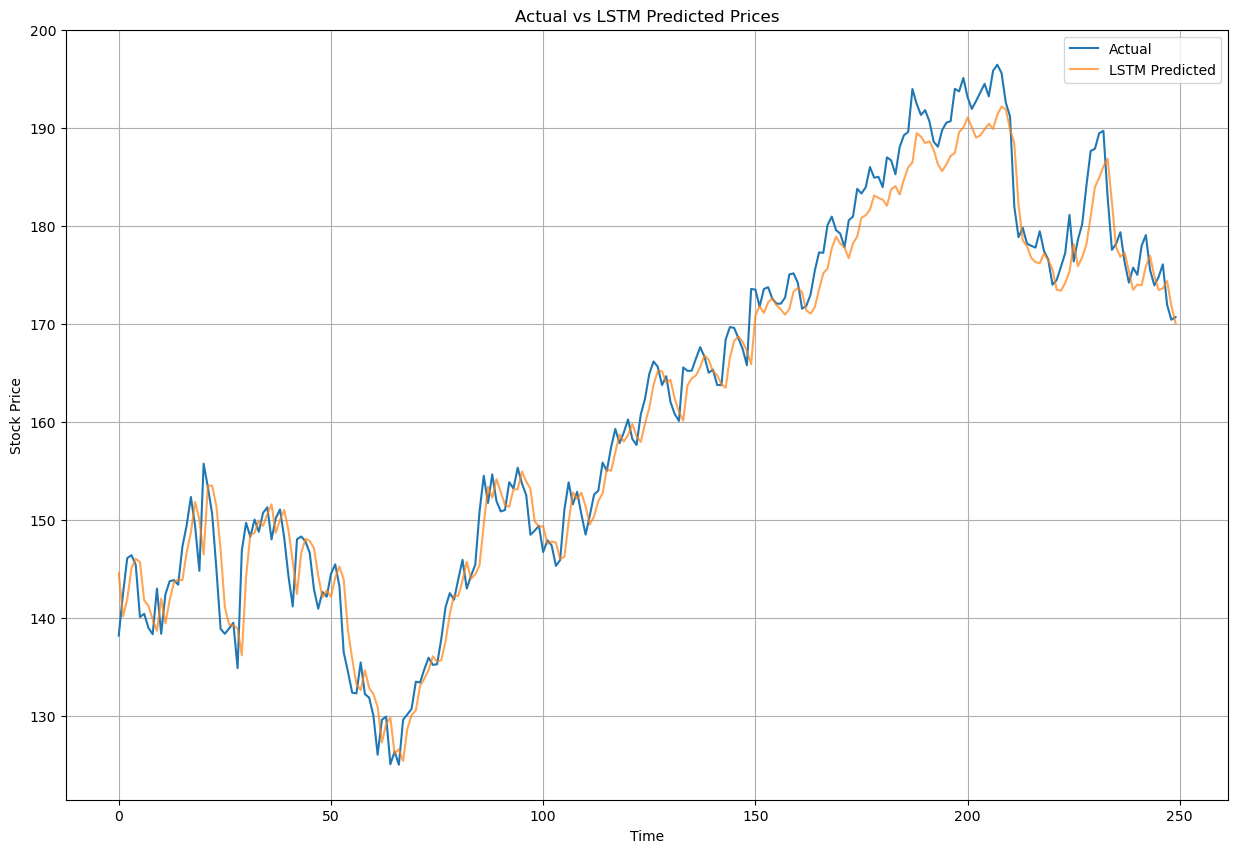

In [6]:
X_train_lstm = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test_lstm = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

model = Sequential()
model.add(LSTM(50, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train_lstm, Y_train, epochs=100, batch_size=1, verbose=1)

lstm_predictions = model.predict(X_test_lstm)
lstm_predictions_actual = scaler.inverse_transform(lstm_predictions)
Y_test_actual = scaler.inverse_transform([Y_test])

plot_data(Y_test_actual[0], lstm_predictions_actual, 
          "Actual vs LSTM Predicted Prices", "Time", "Stock Price", ["Actual", "LSTM Predicted"])

# Linear Regression Model

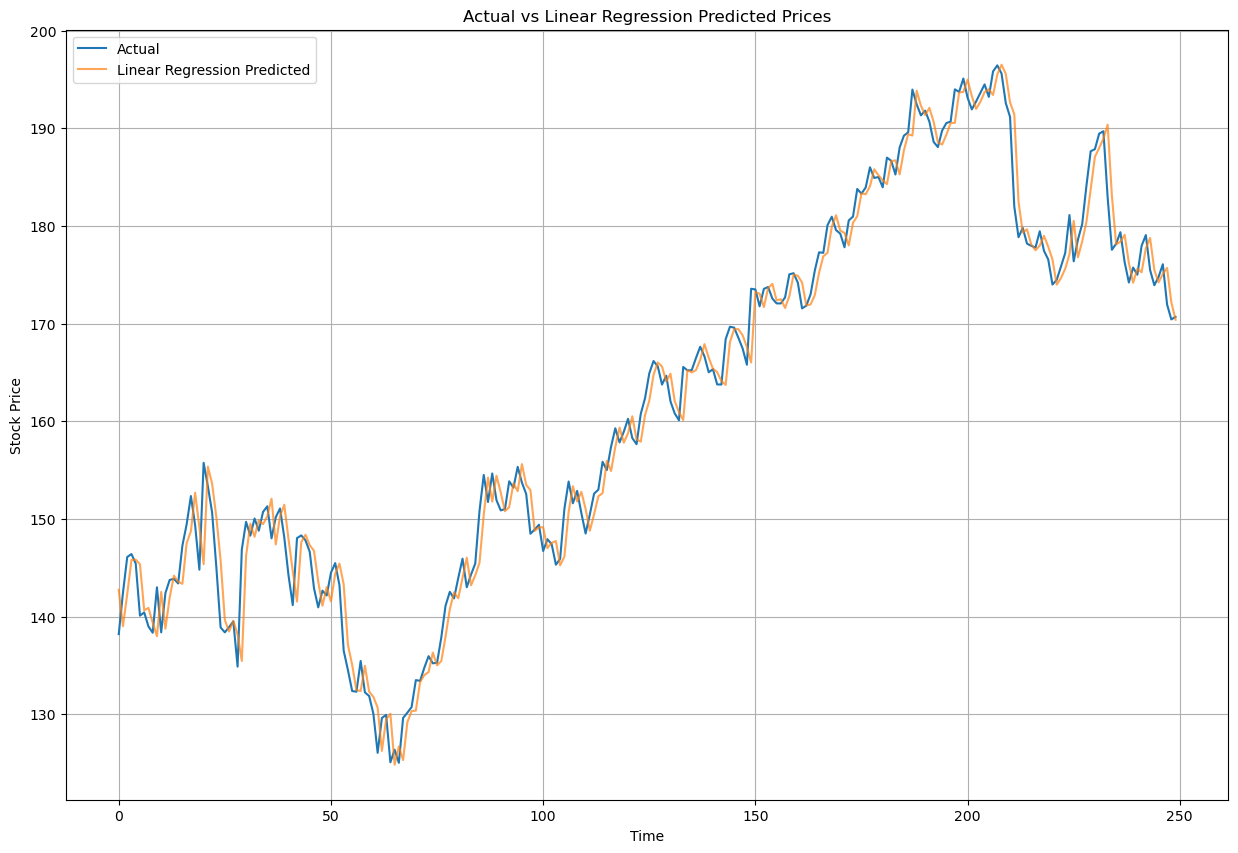

In [7]:
lr_model = LinearRegression()
lr_model.fit(X_train, Y_train)

lr_predictions = lr_model.predict(X_test)
lr_predictions_actual = scaler.inverse_transform(lr_predictions.reshape(-1, 1))

plot_data(Y_test_actual[0], lr_predictions_actual, 
          "Actual vs Linear Regression Predicted Prices", "Time", "Stock Price", ["Actual", "Linear Regression Predicted"])



# Comparison Plot

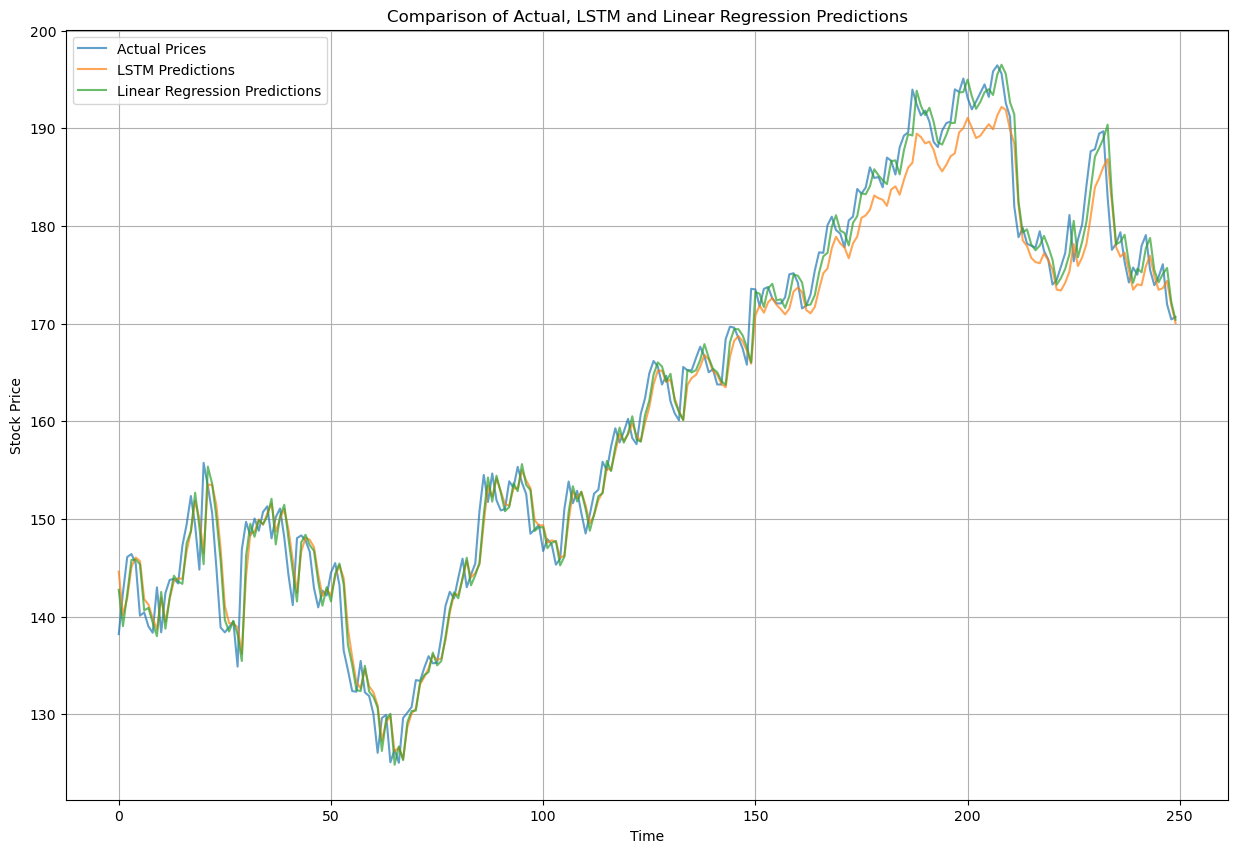

In [8]:
plt.figure(figsize=(15, 10))
plt.plot(Y_test_actual[0], label='Actual Prices', alpha=0.7)
plt.plot(lstm_predictions_actual, label='LSTM Predictions', alpha=0.7)
plt.plot(lr_predictions_actual, label='Linear Regression Predictions', alpha=0.7)
plt.title("Comparison of Actual, LSTM and Linear Regression Predictions")
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.legend()
plt.grid(True)
plt.show()

# predict stock price.

In [12]:
# Number of future days to predict
num_days = 50

# Function to predict future stock prices
def predict_future_prices(model, recent_data, num_days=50, model_type="lstm"):
    future_predictions = []

    for _ in range(num_days):
        if model_type == "lstm":
            data = np.reshape(recent_data, (1, 1, len(recent_data)))
            prediction = model.predict(data)
        else:  # for linear regression
            data = np.reshape(recent_data, (1, -1))  # Reshape data to 2D for linear regression
            prediction = model.predict(data)

        future_predictions.append(prediction[0])
        recent_data = np.append(recent_data[1:], prediction)

    return future_predictions

# Predict future prices using LSTM and Linear Regression
last_known_data = scaled_data[-look_back:]
future_lstm = predict_future_prices(model, last_known_data, num_days=num_days, model_type="lstm")
future_lr = predict_future_prices(lr_model, last_known_data, num_days=num_days, model_type="lr")

future_lstm_actual = scaler.inverse_transform(np.array(future_lstm).reshape(-1, 1))
future_lr_actual = scaler.inverse_transform(np.array(future_lr).reshape(-1, 1))

# Creating a date range for the predictions
last_date = pd.to_datetime(data['Date'].iloc[-1])
future_dates = [last_date + pd.DateOffset(days=i) for i in range(1, num_days+1)]

# Interactive interface
while True:
    input_date = input(f"Enter a date between {future_dates[0].strftime('%Y-%m-%d')} and {future_dates[-1].strftime('%Y-%m-%d')} (or 'exit' to stop): ")
    
    if input_date.lower() == 'exit':
        break

    try:
        input_date = pd.to_datetime(input_date)
        if input_date in future_dates:
            index = future_dates.index(input_date)
            print(f"Predicted Stock Price on {input_date.strftime('%Y-%m-%d')} based on LSTM: ${future_lstm_actual[index][0]:.2f}")
            print(f"Predicted Stock Price on {input_date.strftime('%Y-%m-%d')} based on Linear Regression: ${future_lr_actual[index][0]:.2f}")
        else:
            print("Date out of range. Please input a date within the specified range.")
    except ValueError:
        print("Invalid date format. Please use 'YYYY-MM-DD'.")


1/1 [==============================] - 0s 23ms/step
Enter a date between 2023-09-30 and 2023-11-18 (or 'exit' to stop): exit


# Risk Management on the stock price

# value at risk

In [13]:
import numpy as np

def calculate_var(returns, confidence_level=0.95):
    """
    Calculate and return the Value at Risk (VaR) for a set of returns.
    :param returns: array-like, daily returns of the asset or portfolio
    :param confidence_level: float, the confidence level to compute the VaR
    :return: float, the VaR value
    """
    if isinstance(returns, list):
        returns = np.array(returns)

    return np.percentile(returns, 100 * (1 - confidence_level))


# Conditional Value at Risk (CVaR)

In [14]:
def calculate_cvar(returns, confidence_level=0.95):
    """
    Calculate and return the Conditional Value at Risk (CVaR) for a set of returns.
    :param returns: array-like, daily returns of the asset or portfolio
    :param confidence_level: float, the confidence level to compute the VaR
    :return: float, the CVaR value
    """
    if isinstance(returns, list):
        returns = np.array(returns)

    var = calculate_var(returns, confidence_level)
    return returns[returns < var].mean()


# Portfolio Diversification

In [18]:
import pandas as pd

def portfolio_correlation_matrix(returns_df):
    """
    Calculate and return the correlation matrix for assets in a portfolio.
    :param returns_df: DataFrame, daily returns of all assets in the portfolio
    :return: DataFrame, the correlation matrix
    """
    return returns_df.corr()

# Assuming `data` is the dataframe containing your stock prices with 'AAPL' column
data = pd.read_csv("AAPL.csv")  # Load the stock prices from your CSV
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# Calculate daily returns
returns_df = data.pct_change().dropna()
print(returns_df.head())

asset = "Adj Close"  # Or use "Close" if you prefer
var_value = calculate_var(returns_df[asset])
cvar_value = calculate_cvar(returns_df[asset])
correlation_matrix = portfolio_correlation_matrix(returns_df)


                Open      High       Low     Close  Adj Close    Volume
Date                                                                   
2018-10-03  0.012321  0.015087  0.013899  0.012169   0.012169  0.155986
2018-10-04  0.003173 -0.004797 -0.013274 -0.017581  -0.017581  0.118207
2018-10-05 -0.012219 -0.016957 -0.027125 -0.016229  -0.016229  0.048015
2018-10-08 -0.025224 -0.015805 -0.001723 -0.002318  -0.002318 -0.116633
2018-10-09  0.006435  0.010988  0.009310  0.013853   0.013854 -0.093477


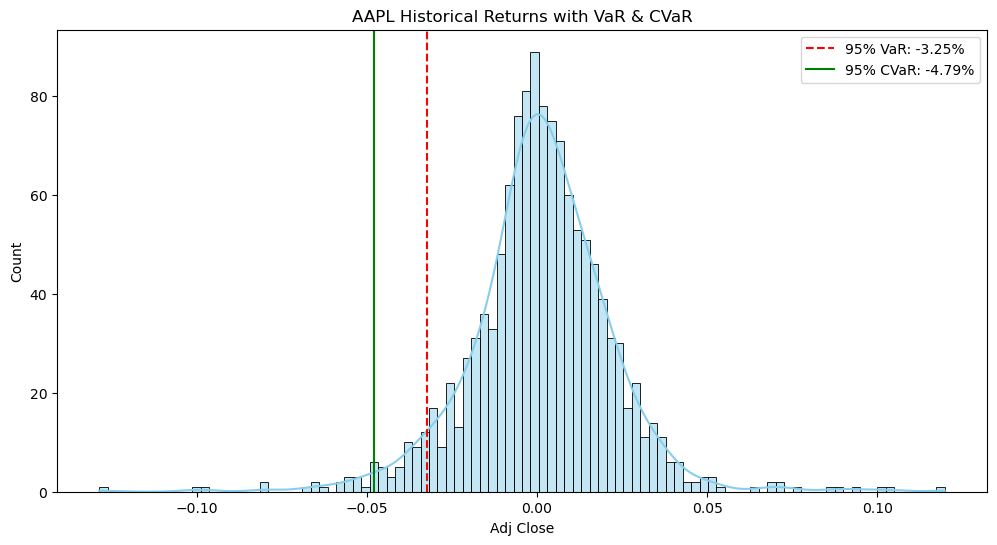

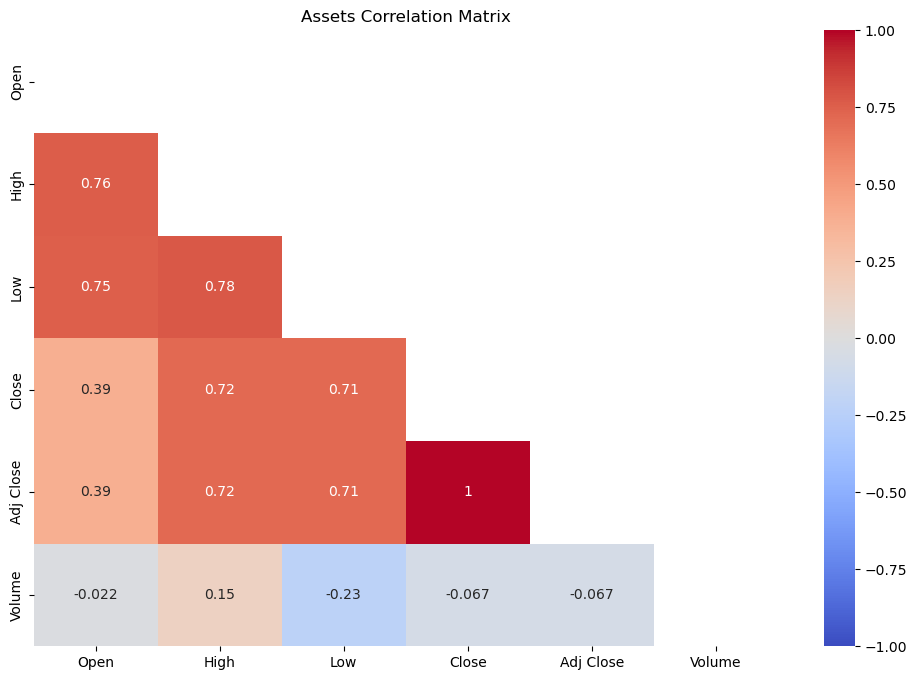

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Assuming returns_df contains daily returns and 'AAPL' is one of the columns

# 1. Historical returns histogram with VaR and CVaR indicators
def plot_var_cvar(returns, asset_name):
    plt.figure(figsize=(12,6))
    sns.histplot(returns, bins=100, kde=True, color='skyblue')
    var_95 = calculate_var(returns)
    cvar_95 = calculate_cvar(returns)
    
    plt.axvline(x=var_95, color='r', linestyle='--', label=f"95% VaR: {var_95:.2%}")
    plt.axvline(x=cvar_95, color='g', linestyle='-', label=f"95% CVaR: {cvar_95:.2%}")
    
    plt.title(f"{asset_name} Historical Returns with VaR & CVaR")
    plt.legend()
    plt.show()

plot_var_cvar(returns_df['Adj Close'], 'AAPL')


# 2. Correlation matrix heatmap
def plot_correlation_matrix(returns_df):
    plt.figure(figsize=(12,8))
    
    # Compute correlation matrix
    corr = portfolio_correlation_matrix(returns_df)
    
    # Generate a mask for the upper triangle (optional)
    mask = np.triu(np.ones_like(corr, dtype=bool))
    
    sns.heatmap(corr, mask=mask, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title("Assets Correlation Matrix")
    plt.show()

plot_correlation_matrix(returns_df)


#  Given the data and the various analyses we've conducted on the stock prices of Apple (AAPL), we can draw the following conclusions:

1. Stock Price Predictions:
    - LSTM (Long Short-Term Memory) models provide a sophisticated method to model sequential data like stock prices. They captured patterns in historical stock price data to make future predictions.
    - Linear Regression, although simple, can sometimes be effective in forecasting short-term trends but is based on the assumption that past linear trends will continue.
    
2. Risk Management Analysis:
    - Value at Risk (VaR): The calculated VaR gives us a risk threshold level, beyond which there is only a small probability that the investment's returns would drop. In simpler terms, VaR provides a worst-case scenario given a confidence interval. The lower this number (more negative), the riskier the stock is considered to be.
    - Conditional Value at Risk (CVaR): CVaR, or Expected Shortfall, gives an idea of the expected return of the stock on its worst-performing days. CVaR is always worse (i.e., lower) than VaR for a given confidence level. It provides a more holistic view of potential loss compared to VaR.
    - Correlation Analysis: If you have a portfolio of assets, it's beneficial to understand how they move in relation to one another. Assets that are highly correlated might not provide the diversification benefits one might expect.

3. General Observations:
    - Machine Learning, especially deep learning, requires a lot of data for training to produce reliable predictions. The more data we have, the better the LSTM network will perform.
    - Stock price prediction is inherently difficult due to the myriad of factors affecting stock prices (e.g., global events, company news, market sentiment). This is why predictions should always be taken with a grain of caution and never solely relied upon for investment.
    - A hybrid approach that combines both quantitative analysis (like what we did) and qualitative analysis (like studying company fundamentals, market news) is usually the best strategy in stock market investment.

